# Diabetic analysis & modeling
## 1. Exploratory Data Analysis

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv("../data/diabetic_data.csv")

In [3]:
df.replace("?", np.nan, inplace=True)

In [4]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

- There are 50 columns and more than 100k rows for the diabetic data
- The target label is **readmitted** which is category with 3 labels: 
    - "No": No readmission for inpatient
    - ">30": patient was readmitted in 30 days or more
    - "<30": patient was readmitted in less than 30 days
- There are total 48 input variables

In [5]:
df = df.drop(["encounter_id","patient_nbr"],axis=1)

### 1.1. Missing values & Imputation
#### 1.1.1. Missing values

In [6]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_pct = missing_values / len(df) * 100


In [7]:
missing_pct.index

Index(['weight', 'medical_specialty', 'payer_code', 'race', 'diag_3', 'diag_2',
       'diag_1'],
      dtype='object')

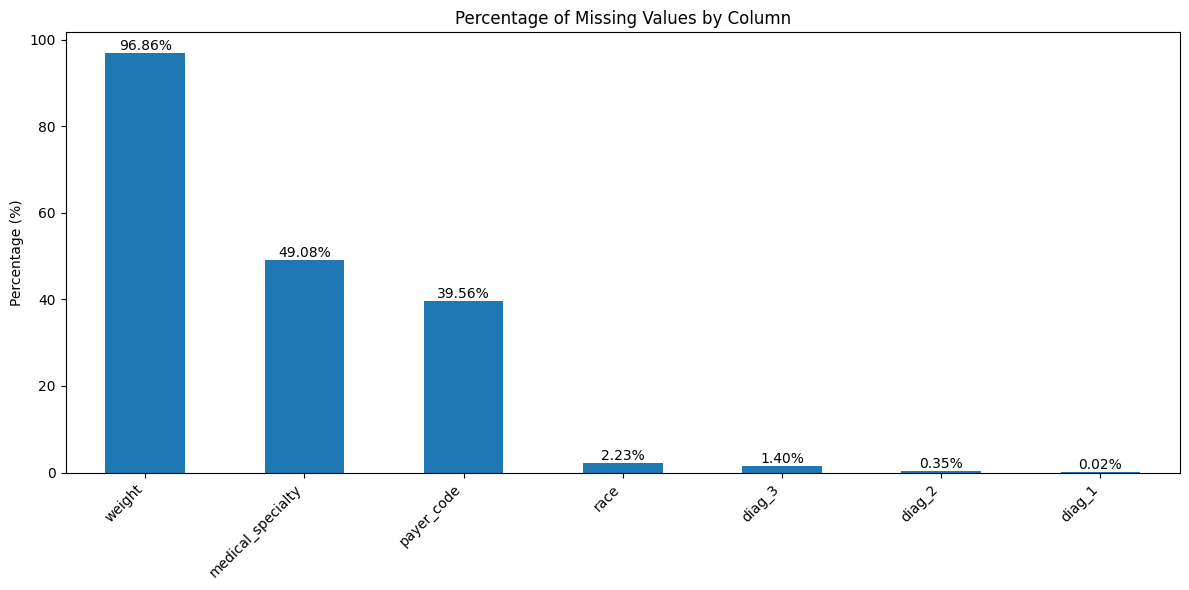

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
missing_pct.plot(kind='bar', ax=ax)
for idx,vals in enumerate(missing_pct):
    ax.text(idx, vals, f"{vals:.2f}%", ha='center', va='bottom')
ax.set_title('Percentage of Missing Values by Column')
ax.set_ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


In [9]:
df.medical_specialty.value_counts(normalize=True)*100

InternalMedicine                    28.243627
Emergency/Trauma                    14.599456
Family/GeneralPractice              14.358222
Cardiology                          10.328657
Surgery-General                      5.980663
                                      ...    
Perinatology                         0.001930
Neurophysiology                      0.001930
Psychiatry-Addictive                 0.001930
Pediatrics-InfectiousDiseases        0.001930
Surgery-PlasticwithinHeadandNeck     0.001930
Name: medical_specialty, Length: 72, dtype: float64

- Out of 48 input variables, 9 variables have missing values
- **Weight** is a numeric variable and has 97% missing value. Although it is important feature, but due to lots of missing values, we have to ignore this variable.
- Similarly, we remove **max_glu_serum and A1Cresult** due to major missing values
- Medical_Specialty containts information for the treatment procedure. It has about 49% missing values. According to suggestion, we will convert the missing value to None and apply OHE to this.
- Similarly, we will apply the same for **payer_code** and **race**
- diag1, diag2, diag3 will be combined and imputed in the later part

#### 1.1.2. Imputations
- First remove **weight** column

In [10]:
df = df.drop(["weight","max_glu_serum","A1Cresult"],axis=1)

- Next, impute **medical_specialty** with **None**
- To reduce the dimension of this variable, we merge all categorical with less than 1% occurrence to the new variable called **Rest**


In [11]:
df.medical_specialty.fillna("None",inplace=True)
small_specialty = df.medical_specialty.value_counts(normalize=True)*100
df.medical_specialty = df.medical_specialty.replace(small_specialty.index[small_specialty<=1].values,"Rest")

- Impute **payer_code**

In [12]:
df.payer_code.fillna("None",inplace=True)
small_pcode = df.payer_code.value_counts(normalize=True)*100
df.payer_code = df.payer_code.replace(small_pcode.index[small_pcode<=1].values,"Rest")

- Impute **race**
- We do not merge any other race for this varialbe due to very small amount of missing value

In [13]:
df.race.fillna("None",inplace=True)

- Impute **diag1, diag2, diag3**: replace Nan value with **None**
- For each diag category, retain the top 1% category value (~top 20 category), the rest convert to **Rest**
- Create new diag column with following criteria:
    - if there are values in diag_1, diag_2 and diag_3: get the value from diag_1 only
    - if there are values in diag_2 and diag_3 only: get the value from diag_2 only
- Keep only diag column and remove the rest    




In [14]:
df.diag_1.fillna("None",inplace=True)
df.diag_2.fillna("None",inplace=True)
df.diag_3.fillna("None",inplace=True)

In [15]:
ind1 = df.diag_1.value_counts(normalize=True)*100
df.diag_1 = df.diag_1.replace(ind1.index[ind1<=1].values,"Rest")

ind2 = df.diag_2.value_counts(normalize=True)*100
df.diag_2 = df.diag_2.replace(ind2.index[ind2<=1].values,"Rest")

ind3 = df.diag_3.value_counts(normalize=True)*100
df.diag_3 = df.diag_3.replace(ind3.index[ind3<=1].values,"Rest")

In [16]:
def pick_diag(row):
    for col in ['diag_1', 'diag_2', 'diag_3']:
        val = row[col]
        if pd.notna(val) and val != 'Rest' and val != 'None':
            return val
    return 'Rest'  # If all are "Rest" or None

# Apply to DataFrame
df['diag'] = df.apply(pick_diag, axis=1)

In [17]:
df = df.drop(["diag_1","diag_2","diag_3"],axis=1)

- Convert **age** from category to numeric

In [18]:
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age_mid'] = df['age'].map(age_map)
df = df.drop(["age"],axis=1)


### 1.2. Catogorical and Numerical data analysis
- Beside the object type categorical variables, there are 3 columns having categorical values in numeric format that need to be treated as categorical variables, they are **admission_type_id, discharge_disposition_id, admission_source_id**

In [19]:
cat_cols = df.select_dtypes("object").columns
df_cat = pd.concat([df[cat_cols],df[["admission_type_id","discharge_disposition_id","admission_source_id"]]],axis=1)

In [20]:
df_num = df.drop(df_cat.columns,axis=1)

df_cat = df_cat.drop(["readmitted"],axis=1)

In [21]:
df_cat.shape

(101766, 33)

#### 1.2.1. Categorical distribution plots

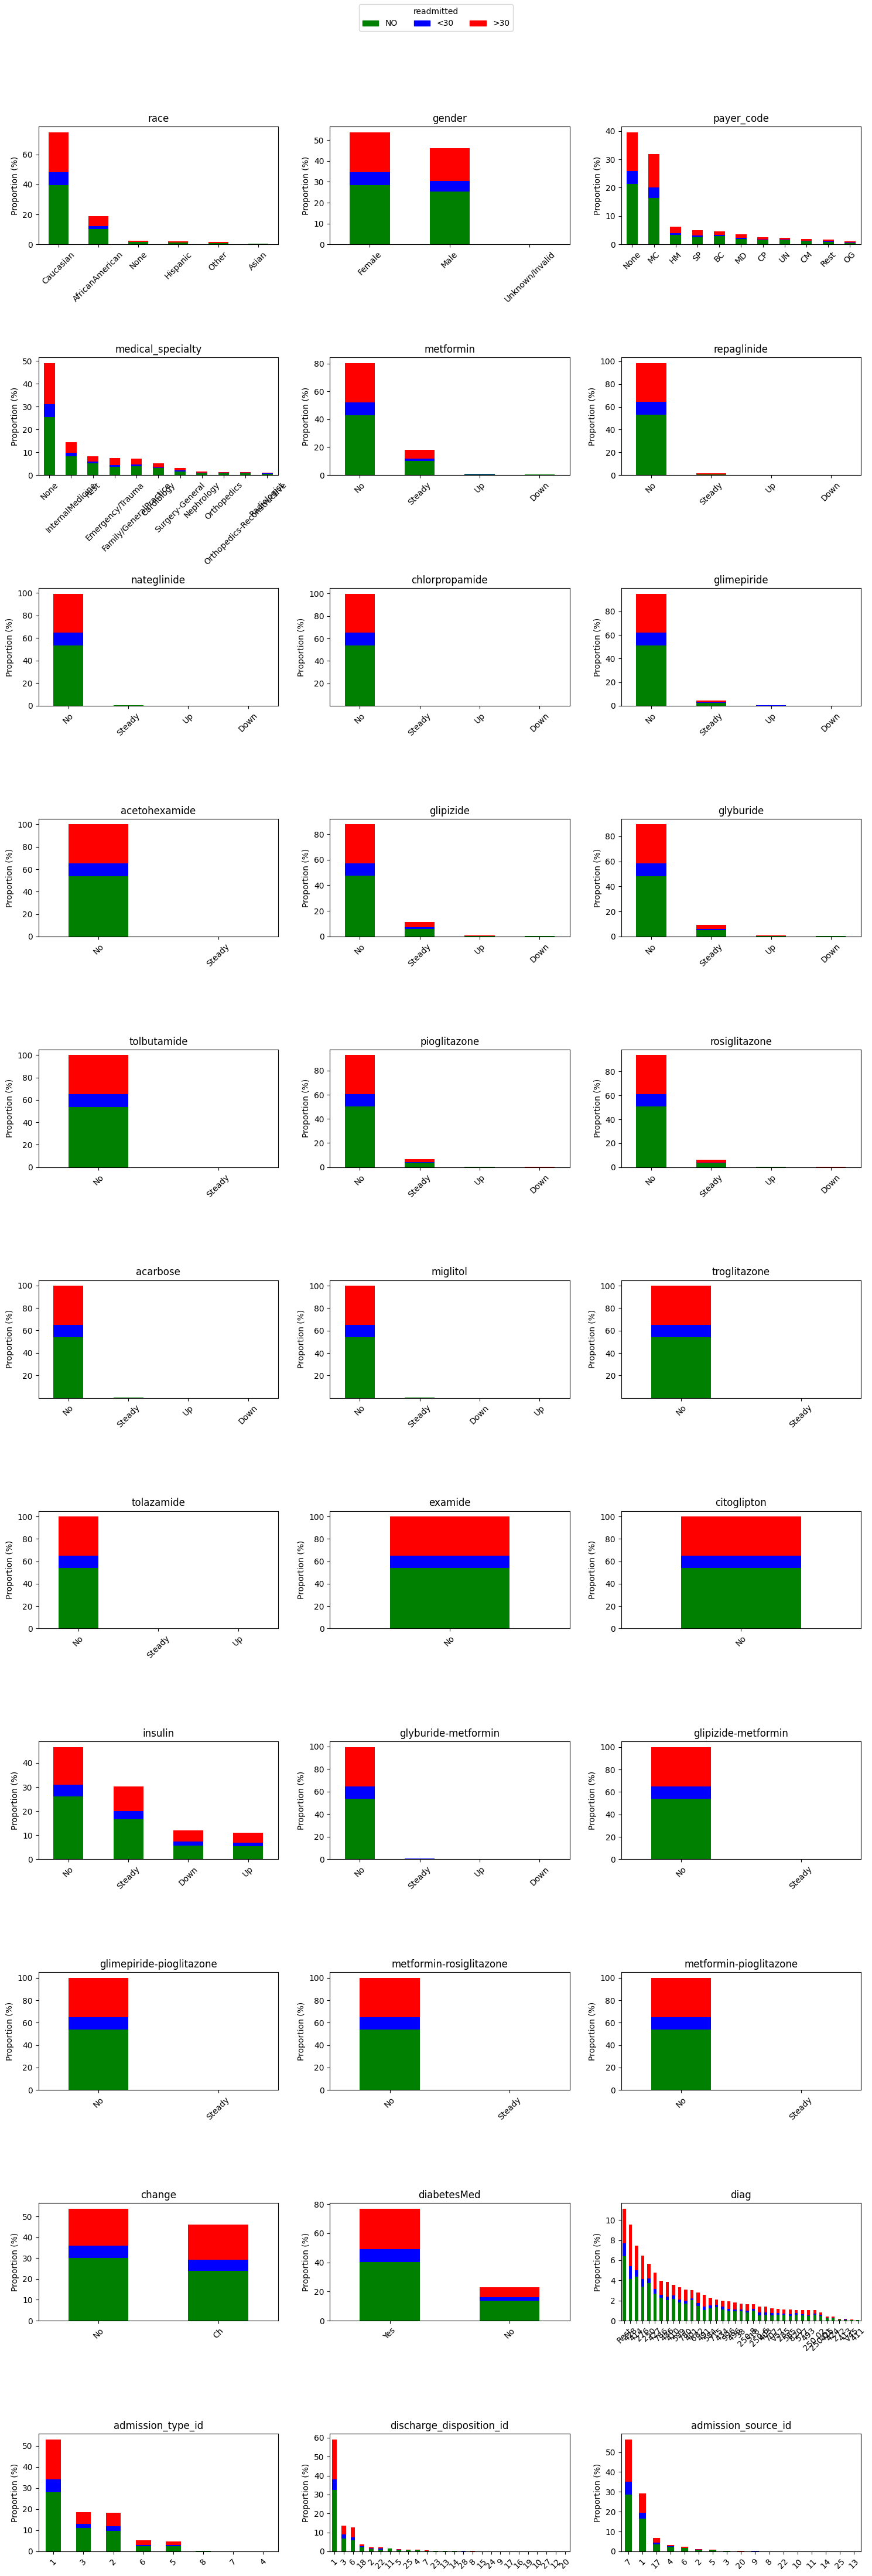

In [22]:
def plot_categorical_grid(df, cat_cols, target_col='readmitted', n_rows=11, n_cols=3):
    # Set up figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    # Define color mapping
    expected_order = ["NO", "<30", ">30"]
    colors = {"NO": "green", "<30": "blue", ">30": "red"}

    for i, col in enumerate(cat_cols):
        ax = axes[i]
        
        # Build count DataFrame
        count_df = (
            df.groupby([col, target_col])
            .size()
            .reset_index(name='count')
            .pivot(index=col, columns=target_col, values='count')
            .fillna(0)
        )

        # Sort by total count descending
        count_df['total'] = count_df.sum(axis=1)
        count_df = count_df.sort_values(by='total', ascending=False).drop(columns='total')

        # Normalize to get proportions
        total_count = count_df.values.sum()
        prop_df = count_df / total_count * 100

        # Reorder columns to expected order
        available_order = [t for t in expected_order if t in prop_df.columns]
        prop_df = prop_df[available_order]

        # Plot
        prop_df.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[colors[c] for c in available_order],
            legend=False
        )

        ax.set_title(col)
        ax.set_ylabel("Proportion (%)")
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=45)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Shared legend
    handles = [plt.Rectangle((0,0),1,1,color=colors[k]) for k in expected_order if k in df[target_col].unique()]
    labels = [k for k in expected_order if k in df[target_col].unique()]
    fig.legend(handles, labels, title=target_col, loc='upper center', ncol=3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_categorical_grid(df, df_cat.columns)

From the categorical plots we can see that: 
- **readmitted**: is the target variables and was plotted against all other categorical input data. The distribution of NO readmittion covers majority followed by ">30" days value
- **race**: more than 70% of patients are caucasian, this having good pattern in comparison to target variable
- Some good distributions that should be retained are: **gender, payer_code, medical_Specialty, metformin, glipizide, glyburide, piolitazone, rosiglitazone, insulin, change, diabetesMed, diag, admission_type_id, discharge_disposition_id, admission_source_id**.
- **admission_type_id**: more than 50% are type 1, which is Emergency intake, while Urgent and Elective are highly ranked behind
- **discharge_disposition_id**: about 60% of diabetic discharge are to home, while 13% are discharge to SNF or home with home health service. So we can see that majority discharge are to home
- **admission_source_id**: similar to admission_type, nearly 60% admission sources are from 7: Emergency room, followed by 30% of 1:Physician Referral
- The following categorical variables are suggested to be removed due to extreme skewness: **repalinize, nateglinide, chloropropamite, acetohesamide, tolbutamide, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, gliburide_metoformin, glipizide_metoformin, gplipiride_glitopetazone, troglitazone, metorformin_piglitazone**

In [23]:
df_cat_keep = df[["race","gender","payer_code","medical_specialty","metformin","glimepiride","glipizide","glyburide","pioglitazone",
                  "rosiglitazone","insulin","change","diabetesMed","diag","admission_type_id", "discharge_disposition_id", "admission_source_id"]]

#### 1.2.2. Numerical data analysis

In [24]:
corr = df_num.corr(method="pearson")

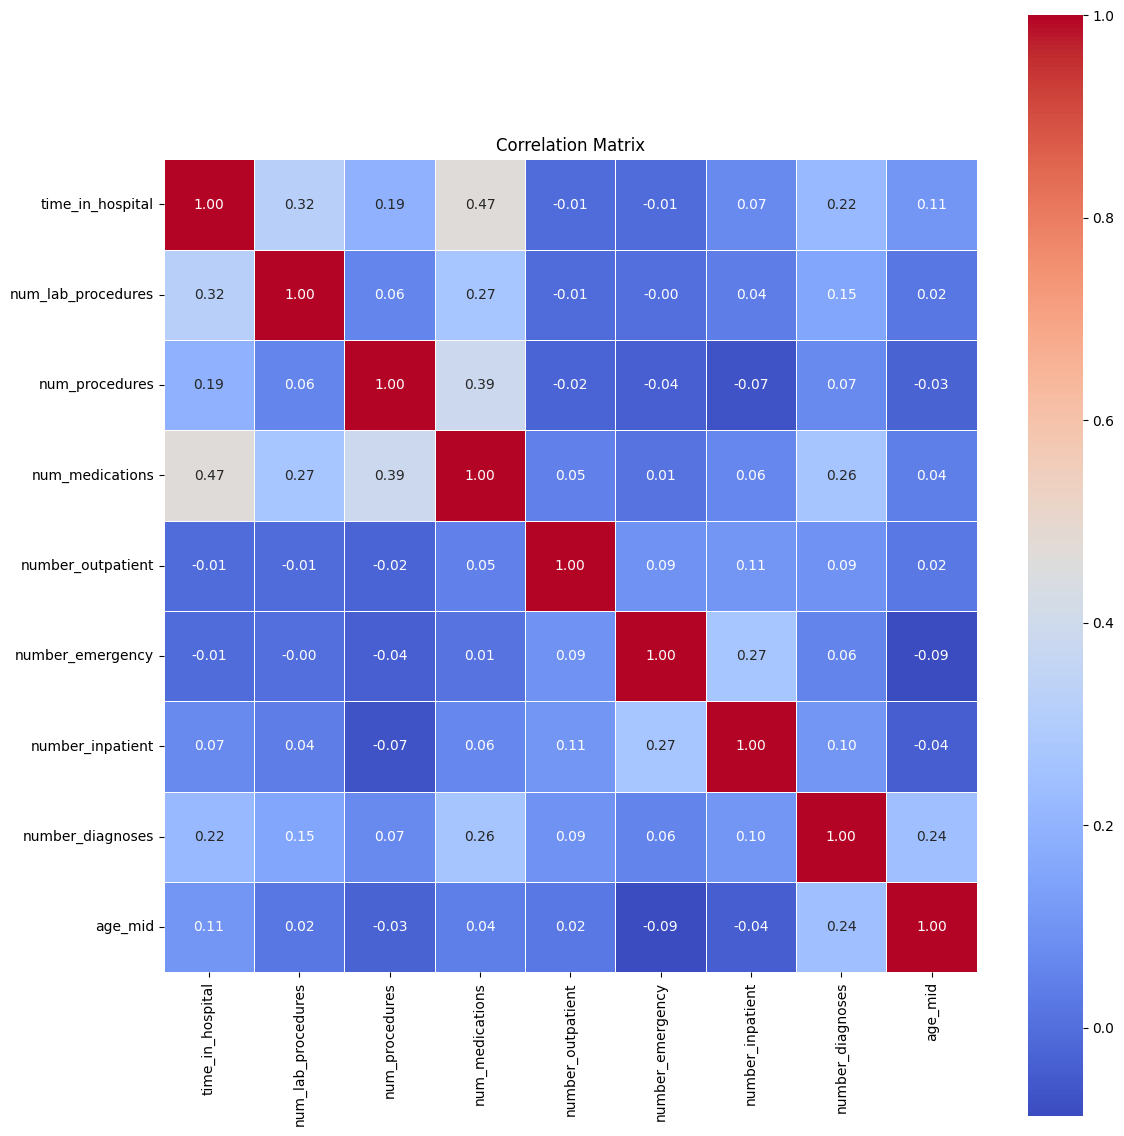

In [25]:
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

- Cross correlation matrix does not exhibit high collinearity between numeric variables
- Next we compute VIF to check if there is any significant collinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = df_num.columns
vif_data['VIF'] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]


In [32]:
vif_data


,Feature,VIF
0,time_in_hospital,4.340958
1,num_lab_procedures,6.136998
2,num_procedures,1.924524
3,num_medications,7.414371
4,number_outpatient,1.114089
5,number_emergency,1.137833
6,number_inpatient,1.386577
7,number_diagnoses,15.119873
8,age_mid,12.191943


Text(0, 0.5, 'VIF')

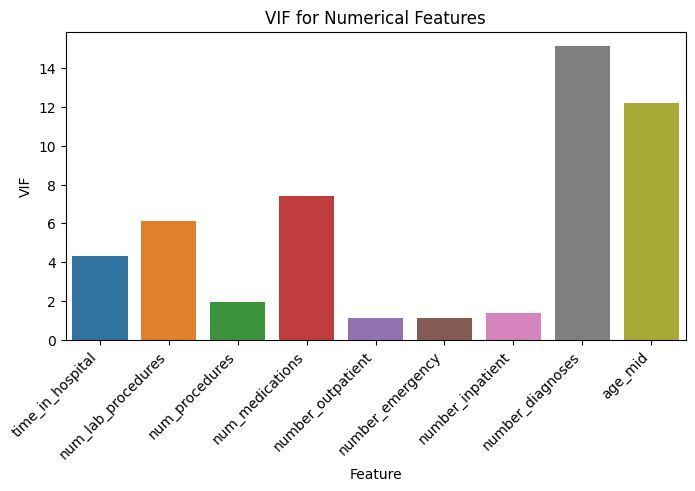

In [39]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=vif_data,x="Feature",y="VIF")
plt.title("VIF for Numerical Features")
plt.xticks(rotation=45,ha="right")
plt.ylabel("VIF")


- The VIF analysis shows potential high collinearity between number_dianoses and age, however, the VIF values are in acceptable range. Hence we do not remove anything
- We just need to standardize these numerical value prior to merging with categorical value
- We will proceed to One Hot Encoding and data partitioning



### 1.3. One Hot Encoding categorical values
- There are 33 original categorical variables
- After EDA, we narrow down to 17 categorical variables
- Now, we apply One Hot Encoding to 17 variables and we have 153 new variables
- Merge this new OHE dataframe with standardized numerical data to have X dataframe


In [40]:
df_cat_keep = df_cat_keep.astype(str)
df_cat_ohe = pd.get_dummies(df_cat_keep,drop_first=False,dtype=int)

In [52]:
df_num_std = pd.DataFrame(StandardScaler().fit_transform(df_num))
df_num_std.columns = df_num.columns

In [53]:
X = pd.concat([df_cat_ohe,df_num_std],axis=1)
y = df["readmitted"]

### 1.4. Partition X and y to training and testing set

In [54]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=123)

## 2. Modeling
### 2.1. Logistic Regression
#### Perform K-Fold Cross Validation

In [55]:
kf = KFold(n_splits=10,shuffle=True,random_state=123)

In [56]:
model_logreg = LogisticRegressionCV(
        Cs=10,                     # Number or list of regularization values to try
        cv=10,                      # Number of cross-validation folds
        multi_class='multinomial',# For softmax-style multi-class
        solver='lbfgs',           # Good for multiclass
        max_iter=1000,
        scoring='accuracy',
        random_state=123
    )

In [57]:
model_logreg.fit(X_train, y_train)


c:\Users\46791130\.conda\envs\torch_yolo\lib\site-packages\sklearn\linear_model\_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegressionCV(cv=10, max_iter=1000, multi_class='multinomial',
                     random_state=123, scoring='accuracy')

In [58]:
y_pred = model_logreg.predict(X_test)


In [61]:
# Best C chosen for each class
#model = model_logreg.named_steps['logisticregressioncv']
#print("Best C per class:", model.C_)

# Accuracy
from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.5796403655301169


In [77]:
importance = np.abs(model_logreg.coef_)      # take absolute value
X_df = pd.DataFrame(importance, columns=X.columns)


In [75]:
X_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_None,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,payer_code_BC,...,admission_source_id_9,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_mid
0,0.007184,0.082756,0.020520,0.009806,0.065243,0.033016,0.017873,0.043386,0.073232,0.027070,...,0.637072,0.001603,0.002144,0.005499,0.023962,0.004411,0.073009,0.260049,0.036216,0.034589
1,0.085044,0.176638,0.081672,0.057129,0.026125,0.046668,0.031022,0.014214,0.156651,0.103896,...,0.618520,0.024522,0.004913,0.025806,0.013792,0.053362,0.068381,0.084449,0.036657,0.001497
2,0.077860,0.093882,0.102192,0.066935,0.091367,0.079684,0.048895,0.029172,0.229883,0.130966,...,0.018552,0.022919,0.002770,0.020307,0.010170,0.057773,0.141390,0.344498,0.072872,0.036086


In [83]:
X_df.iloc[0,:].sort_values(ascending=False)

discharge_disposition_id_11    2.121185
discharge_disposition_id_15    1.164478
discharge_disposition_id_28    1.132452
discharge_disposition_id_22    0.649332
admission_source_id_9          0.637072
                                 ...   
change_No                      0.002817
payer_code_MD                  0.002740
num_lab_procedures             0.002144
time_in_hospital               0.001603
discharge_disposition_id_20    0.000000
Name: 0, Length: 162, dtype: float64

In [84]:
X_df.iloc[1,:].sort_values(ascending=False)

discharge_disposition_id_11    2.395588
discharge_disposition_id_14    1.645368
admission_type_id_7            0.695544
discharge_disposition_id_16    0.663360
admission_source_id_9          0.618520
                                 ...   
metformin_Steady               0.001610
age_mid                        0.001497
payer_code_CM                  0.000169
glimepiride_No                 0.000129
discharge_disposition_id_20    0.000000
Name: 1, Length: 162, dtype: float64

In [85]:
X_df.iloc[2,:].sort_values(ascending=False)

discharge_disposition_id_11    4.516772
discharge_disposition_id_14    1.638842
discharge_disposition_id_15    1.049571
admission_type_id_7            1.016012
discharge_disposition_id_13    0.938261
                                 ...   
payer_code_UN                  0.008258
diag_425                       0.005294
num_lab_procedures             0.002770
discharge_disposition_id_17    0.000549
discharge_disposition_id_20    0.000000
Name: 2, Length: 162, dtype: float64

## 2.2 Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
modelrf = RandomForestClassifier()

In [88]:
modelrf.fit(X_train,y_train)

RandomForestClassifier()

In [89]:
ypred = modelrf.predict(X_test)

In [90]:
print("Test Accuracy:", accuracy_score(y_test, ypred))


Test Accuracy: 0.5809177557236906


In [92]:
importances = modelrf.feature_importances_  # array of importance values
indices = np.argsort(importances)[::-1]   # sort in descending order

# Print feature ranking
for i in range(X.shape[1]):
    print(f"{i+1}. Feature: {X.columns[indices[i]]} - Importance: {importances[indices[i]]:.4f}")


1. Feature: num_lab_procedures - Importance: 0.0840
2. Feature: num_medications - Importance: 0.0752
3. Feature: time_in_hospital - Importance: 0.0573
4. Feature: age_mid - Importance: 0.0489
5. Feature: number_inpatient - Importance: 0.0429
6. Feature: number_diagnoses - Importance: 0.0401
7. Feature: num_procedures - Importance: 0.0375
8. Feature: number_outpatient - Importance: 0.0180
9. Feature: gender_Female - Importance: 0.0157
10. Feature: gender_Male - Importance: 0.0155
11. Feature: number_emergency - Importance: 0.0145
12. Feature: medical_specialty_None - Importance: 0.0136
13. Feature: payer_code_None - Importance: 0.0132
14. Feature: payer_code_MC - Importance: 0.0131
15. Feature: race_Caucasian - Importance: 0.0122
16. Feature: discharge_disposition_id_1 - Importance: 0.0111
17. Feature: race_AfricanAmerican - Importance: 0.0107
18. Feature: insulin_Steady - Importance: 0.0106
19. Feature: diag_Rest - Importance: 0.0100
20. Feature: admission_type_id_1 - Importance: 0.009